In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data

# "текущие цены, млрд. (трлн.) рублей"
# привести к ценам одного года
i_raw = pd.read_csv('Data/Investments.csv', sep=";")

# Инфляция (ежемесячная)
inflation = pd.read_csv("Data/data_input/inflation.csv")

# ВВП - млрд руб
gdp1_raw = pd.read_csv("Data/gdp_1995_2011_in_2008_prices.csv", sep=";")
gdp3_raw = pd.read_csv("Data/gdp_2011_2022_in_2016_prices.csv", sep=";")

def1_raw = pd.read_csv("Data/index_def_gdp_1996_2011_in_prev_year_prices_percent.csv", sep=";")
def2_raw = pd.read_csv("Data/index_def_gdp_2012_2023_in_prev_year_prices_percent.csv", sep=";")

In [3]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:

    quarter_dict = {
        "I квартал": "01.01",
        "II квартал": "04.01",
        "III квартал": "07.01",
        "IV квартал": "10.01"
    }

    df = df.copy(deep=True)
    df = df.T
    df.reset_index(inplace=True)
    df.columns = ["Year", "Quarter_str", "Value"]
    df["Year"] = df["Year"].map(lambda x: None if "Unnamed:" in x else x)
    df["Year"].ffill(inplace=True)

    df["Quarter_num"] = df.Quarter_str.map(quarter_dict)
    df["Date"] = df.Year + "." + df.Quarter_num
    df["Date"] = pd.to_datetime(df["Date"])

    df.Value = df.Value.map(lambda x: x.replace(",", "."))
    df.Value = df.Value.map(lambda x: x.replace(" ", "")).astype("float")

    if not all(df["Date"].dt.day.unique() == 1):
        # проверка на корректный парсинг дат
        raise Exception ("Некорректный парсинг дат: Возможно перепутан день и месяц в формате дат")

    df_final = df[["Date", "Value"]]
    return df_final


# GDP

In [4]:
# первый шаг обработки данных
def1 = prepare_data(def1_raw)
def2 = prepare_data(def2_raw)

In [5]:
# данные по дефлятору ВВП за временные периоды 1996 - 2022 (включительно)
def_gdp = pd.concat([def1, def2], axis="rows", ignore_index=True)

In [6]:
# данные по дефлятору ВВП за временные периоды 2008 - 2016 (включительно)
# необходисы для расчёта индекса, позволяющего привести ряд к базовым ценам (2016 года)
def_gdp_filtered = def_gdp[
    (def_gdp.Date >= "2008-01-01") & (
        def_gdp.Date < "2017-01-01"
    )
]

In [7]:
# группируем поквартально данные для расчёта индекса
index_linked_q1 = def_gdp_filtered[def_gdp_filtered.Date.dt.month == 1]
index_linked_q1

,Date,Value
48,2008-01-01,119.9
52,2009-01-01,103.4
56,2010-01-01,115.2
60,2011-01-01,115.8
64,2012-01-01,110.3
68,2013-01-01,106.6
72,2014-01-01,105.8
76,2015-01-01,108.3
80,2016-01-01,102.5


In [8]:
# определяем итоговый индекс для приведения к базовым ценам
index_linked_q1 = index_linked_q1.Value.to_numpy().prod(axis=0) / 10 ** 18
index_linked_q1

2.283870459356747

In [9]:
index_linked_q2 = def_gdp_filtered[def_gdp_filtered.Date.dt.month == 4]
index_linked_q2 = index_linked_q2.Value.to_numpy().prod(axis=0) / 10 ** 18

index_linked_q3 = def_gdp_filtered[def_gdp_filtered.Date.dt.month == 4]
index_linked_q3 = index_linked_q3.Value.to_numpy().prod(axis=0) / 10 ** 18

index_linked_q4 = def_gdp_filtered[def_gdp_filtered.Date.dt.month == 10]
index_linked_q4 = index_linked_q4.Value.to_numpy().prod(axis=0)  / 10 ** 18

In [10]:
(index_linked_q1,
index_linked_q2,
index_linked_q3,
index_linked_q4)

(2.283870459356747, 2.251006602080749, 2.251006602080749, 2.073739324906258)

In [11]:
gdp1 = prepare_data(gdp1_raw)
gdp3 = prepare_data(gdp3_raw)

In [12]:
# определяем средний индекс для приведения к общим ценам
# поскольку мы расчитали для каждого квартала его отдельно
index_to_basis_prices = sum([index_linked_q1,
index_linked_q2,
index_linked_q3,
index_linked_q4]) / 4

In [13]:
gdp1.Value *= index_to_basis_prices

In [14]:
gdp1 = gdp1[gdp1.Date.dt.year < 2011]

In [15]:
gdp = pd.concat([gdp1, gdp3], axis="rows")
gdp.set_index("Date", inplace=True)
# i.groupby(i.Date.dt.year)["Value"].shift(1).fillna(0)

<Axes: xlabel='Date'>

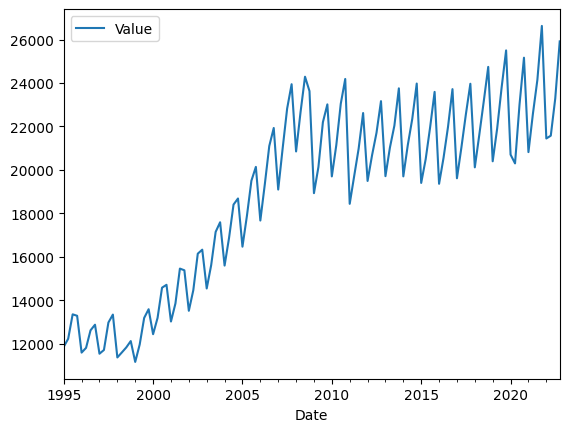

In [17]:
gdp.plot()

In [18]:
gdp["value_lag1"] = gdp.Value.shift(-1)
gdp["value_lag4"] = gdp.Value.shift(-4)
gdp["delta_lag1"] = gdp.Value - gdp.value_lag1
gdp["delta_lag4"] = gdp.Value - gdp.value_lag4
gdp

,Value,value_lag1,value_lag4,delta_lag1,delta_lag4
Date,,,,,
1995-01-01,11860.820276,12233.145932,11595.253077,-372.325656,265.567199
1995-04-01,12233.145932,13355.881655,11813.864274,-1122.735723,419.281658
1995-07-01,13355.881655,13289.877464,12620.754438,66.004191,735.127217
1995-10-01,13289.877464,11595.253077,12879.012448,1694.624387,410.865016
1996-01-01,11595.253077,11813.864274,11544.088754,-218.611197,51.164323
...,...,...,...,...,...
2021-10-01,26624.800000,21446.400000,25913.400000,5178.400000,711.400000
2022-01-01,21446.400000,21574.300000,NaN,-127.900000,NaN
2022-04-01,21574.300000,23288.900000,NaN,-1714.600000,NaN


<Axes: xlabel='Date', ylabel='Value'>

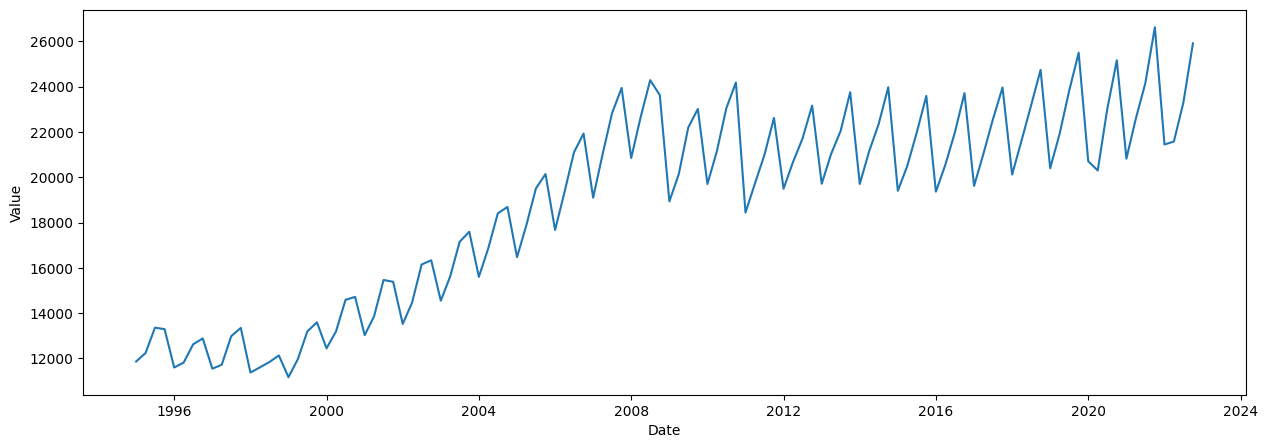

In [20]:
plt.figure(figsize=(15, 5))
sns.lineplot(
    data=gdp, #.set_index("Date"), 
    x="Date", 
    y="Value", 
    #kind="line"
    dashes=False,
    
)

<Axes: xlabel='Date'>

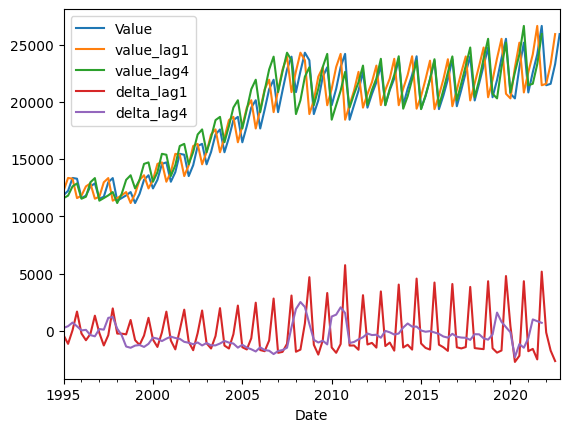

In [22]:
# 
gdp.plot()

## Ряд инфляции

In [23]:
inflation = pd.read_csv("Data/data_prepared/inflation_prepared.csv")

In [24]:
inflation

,Date,Value
0,1993-01-01,1.884040
1,1993-04-01,1.680815
2,1993-07-01,1.896800
3,1993-10-01,1.564718
4,1994-01-01,1.403384
...,...,...
117,2022-04-01,1.013260
118,2022-07-01,0.991416
119,2022-10-01,1.013350
120,2023-01-01,1.016787


In [25]:
inflation1 = inflation[inflation.Date < "2017-01-01"]
inflation1["koeff"] = 1 / inflation1.Value
inflation1.sort_values("Date", ascending=False, inplace=True)
inflation1["koeff"] = inflation1["koeff"].cumprod()
inflation1.sort_values("Date", inplace=True)
inflation1 = inflation1[inflation1["Date"] < "2016-01-01"]
display(inflation1)

,Date,Value,koeff
0,1993-01-01,1.884040,0.000722
1,1993-04-01,1.680815,0.001361
2,1993-07-01,1.896800,0.002287
3,1993-10-01,1.564718,0.004338
4,1994-01-01,1.403384,0.006788
...,...,...,...
87,2014-10-01,1.047858,0.802110
88,2015-01-01,1.074400,0.840498
89,2015-04-01,1.010032,0.903030
90,2015-07-01,1.017294,0.912089


In [26]:
inflation2 = inflation[inflation.Date >= "2016-01-01"]
inflation2["koeff"] = inflation2.Value.cumprod()
inflation2

,Date,Value,koeff
92,2016-01-01,1.020634,1.020634
93,2016-04-01,1.012149,1.033033
94,2016-07-01,1.007210,1.040481
95,2016-10-01,1.012754,1.053751
96,2017-01-01,1.009725,1.063999
97,2017-04-01,1.013155,1.077996
98,2017-07-01,0.993803,1.071316
99,2017-10-01,1.008422,1.080338
100,2018-01-01,1.008122,1.089112
101,2018-04-01,1.012552,1.102783


In [27]:
inflation_series = pd.concat([inflation1, inflation2], axis="rows")[["Date", "koeff"]]
inflation_series["Date"] = pd.to_datetime(inflation_series["Date"])
inflation_series

,Date,koeff
0,1993-01-01,0.000722
1,1993-04-01,0.001361
2,1993-07-01,0.002287
3,1993-10-01,0.004338
4,1994-01-01,0.006788
...,...,...
117,2022-04-01,1.470547
118,2022-07-01,1.457923
119,2022-10-01,1.477386
120,2023-01-01,1.502187


# Investments

In [28]:
def get_prepared_investments_data(
        df: pd.DataFrame
    ) -> pd.DataFrame:

    quarter_dict = {
        "I": "01.01",
        "II": "04.01",
        "III": "07.01",
        "IV": "10.01"
    }

    df = df.copy(deep=True)
    df.columns = ["Quarter_str", "Value"]
    df["Year"] = df["Quarter_str"].map(lambda x: x[:4] if len(x) == 6 else None)
    df.Year.ffill(inplace=True)
    df["Quarter_str"] = df["Quarter_str"].map(lambda x: x[-1:] if len(x) == 6 else x)

    df["Quarter_num"] = df.Quarter_str.map(quarter_dict)
    df["Date"] = df.Year + "." + df.Quarter_num
    df["Date"] = pd.to_datetime(df["Date"])

    #return df
    df.Value = df.Value.map(lambda x: x.replace(",", "."))
    df.Value = df.Value.map(lambda x: x.replace(" ", "")).astype("float")

    if not all(df["Date"].dt.day.unique() == 1):
        # проверка на корректный парсинг дат
        raise Exception ("Некорректный парсинг дат: Возможно перепутан день и месяц в формате дат")

    df_final = df[["Date", "Value"]]
    return df_final

In [29]:
i = get_prepared_investments_data(i_raw)


# Видим, что поквартальные данные по Инвестициям - накопительный показатель (в рамках каждого года)
# Находим чистые инвестиции за каждый квартал

i["Value_lag1"] = i.groupby(i.Date.dt.year)["Value"].shift(1).fillna(0)
#i["Value_lag4"] = i.groupby(i.Date.dt.year)["Value"].shift(4).fillna(0)
i["i_net"] = i.Value - i.Value_lag1
i

,Date,Value,Value_lag1,i_net
0,1993-01-01,1.6,0.0,1.6
1,1993-04-01,3.8,1.6,2.2
2,1993-07-01,6.2,3.8,2.4
3,1993-10-01,15.6,6.2,9.4
4,1994-01-01,12.3,0.0,12.3
...,...,...,...,...
117,2022-04-01,5727.2,3995.1,1732.1
118,2022-07-01,6696.2,5727.2,969.0
119,2022-10-01,11248.9,6696.2,4552.7
120,2023-01-01,4635.8,0.0,4635.8


<Axes: xlabel='Date', ylabel='Value'>

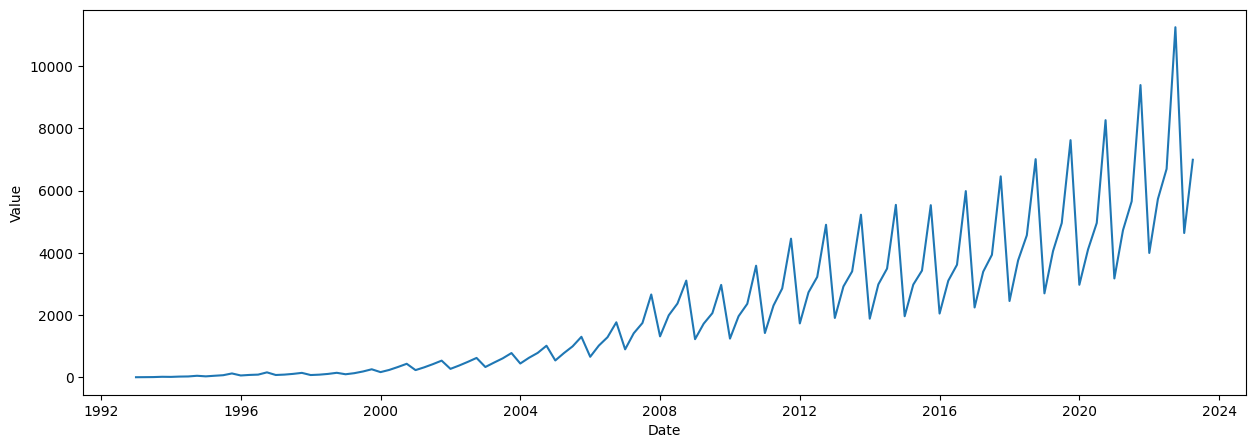

In [31]:
plt.figure(figsize=(15, 5))
sns.lineplot(
    data=i, #.set_index("Date"), 
    x="Date", 
    y="Value", 
    #kind="line"
    dashes=False,
    
)

<Axes: xlabel='Date'>

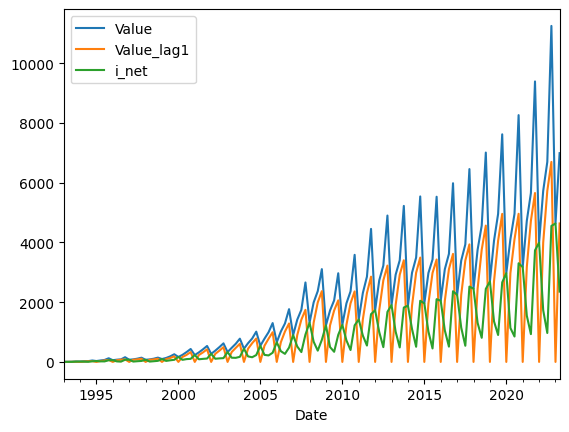

In [33]:
i.plot(x="Date")

In [34]:
# ---
# ПРИВЕДЕНИЕ РЯДА ИНВЕСТИЦИЙ К ЕДИНЫМ ЦЕНАМ
data = i.merge(inflation_series, on="Date")

data["i_net_def"] = data.i_net / data.koeff
# ---

<Axes: xlabel='Date'>

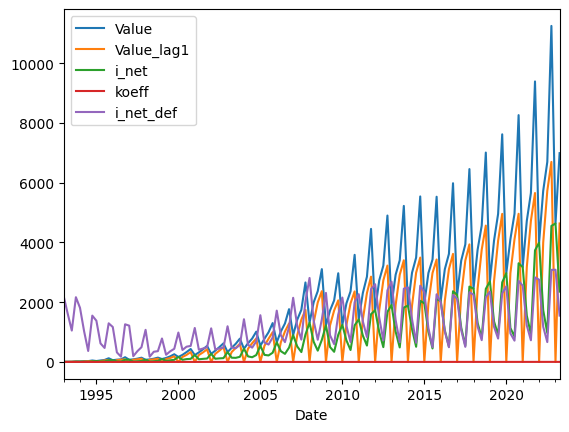

In [36]:
data.plot(x="Date")

In [37]:
data.shape, gdp.shape

((122, 6), (112, 5))

In [38]:
# добавляем ВВП
g = gdp.reset_index()

data_full = data.merge(g, on="Date", suffixes=["_data", "_gdp"])
data_full

,Date,Value_data,Value_lag1,i_net,koeff,i_net_def,Value_gdp,value_lag1,value_lag4,delta_lag1,delta_lag4
0,1995-01-01,29.5,0.0,29.5,0.021385,1379.489045,11860.820276,12233.145932,11595.253077,-372.325656,265.567199
1,1995-04-01,48.4,29.5,18.9,0.030460,620.489984,12233.145932,13355.881655,11813.864274,-1122.735723,419.281658
2,1995-07-01,66.2,48.4,17.8,0.038035,467.993237,13355.881655,13289.877464,12620.754438,66.004191,735.127217
3,1995-10-01,122.8,66.2,56.6,0.043778,1292.891902,13289.877464,11595.253077,12879.012448,1694.624387,410.865016
4,1996-01-01,57.8,0.0,57.8,0.049469,1168.419287,11595.253077,11813.864274,11544.088754,-218.611197,51.164323
...,...,...,...,...,...,...,...,...,...,...,...
107,2021-10-01,9390.4,5655.0,3735.4,1.320004,2829.839646,26624.800000,21446.400000,25913.400000,5178.400000,711.400000
108,2022-01-01,3995.1,0.0,3995.1,1.451303,2752.768013,21446.400000,21574.300000,NaN,-127.900000,NaN
109,2022-04-01,5727.2,3995.1,1732.1,1.470547,1177.861114,21574.300000,23288.900000,NaN,-1714.600000,NaN
110,2022-07-01,6696.2,5727.2,969.0,1.457923,664.644002,23288.900000,25913.400000,NaN,-2624.500000,NaN


In [39]:
# Value_gdp
# delta_lag1
# delta_lag4

model = sm.regression.linear_model.OLS(
    endog=data_full[data_full.Date < "2022-01-01"].i_net_def.to_numpy(),
    exog=sm.add_constant(data_full[data_full.Date < "2022-01-01"].Value_gdp.to_numpy())
)

In [40]:
res = model.fit()

In [41]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     35.59
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           3.26e-08
Time:                        05:59:47   Log-Likelihood:                -855.28
No. Observations:                 108   AIC:                             1715.
Df Residuals:                     106   BIC:                             1720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -478.9650    291.629     -1.642      0.1

In [42]:
res.params

array([-4.78965010e+02,  9.06370215e-02])

In [43]:
data_full["forecast"] = data_full.Value_gdp * res.params[1] + res.params[0]

<Axes: xlabel='Date'>

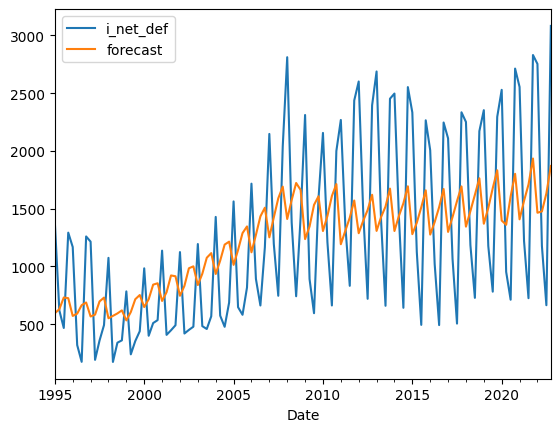

In [45]:
data_full[[
    #"delta_lag1", 
    #"delta_lag4", 
    #"i_net", 
    "i_net_def", 
    "forecast", 
    "Date"
]].plot(x="Date")

# ARIMA

In [46]:
#pip install pmdarima

In [47]:
from statsmodels. tsa.stattools import adfuller, kpss
from pmdarima import auto_arima

In [48]:
# тест Дики-Фуллера 
# немного отличается от стандартного вывода adfuller()

def adf_test(timeseries, regression, maxlag = None):
    """
    тест Дики-Фуллера - проверка на стационарность ряда

    H 0 : Временной ряд является нестационарным. 
    Другими словами, он имеет некоторую структуру, зависящую от времени, 
    и не имеет постоянной дисперсии во времени.

    H A : временной ряд является стационарным.

    Если p-значение из теста меньше некоторого уровня значимости 
    (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу 
    и сделать вывод, что временной ряд является стационарным.


    Бороться с нестационарностью можно множеством способов — разностями различного порядка, 
    выделением тренда и сезонности, 
    сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.
    """

    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag='AIC',
                      store=False, regresults=False)
    
    if dftest[1] < 0.05:
        print(f"ряд является стационарным")
        print("\n\n")
    else:
        print(f"ряд НЕ является стационарным")
        print("\n\n")

    
    results = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag='AIC', 
                       store=True, regresults=True)[3].resols
    
    
    
    results.model.exog_names[0] = 'y(-1)'
    for item in range(dftest[2]):
        results.model.exog_names[item+1] = 'dy(' + str(-item-1) + ')'
    
    trend_len = len(regression) - 1
    if trend_len > 0:
        for item in range(trend_len):
            results.model.exog_names[dftest[2]+item+2] = 'trend' + str(item+1)
        
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    return results


# тест Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
def kpss_test(timeseries, regression):
    """
    Тест KPSS - проверка, является ли временной ряд стационарным трендом

    В этом тесте используются следующие нулевая и альтернативная гипотезы:

    H 0 : Временной ряд имеет стационарный тренд.
    H A : временной ряд не имеет стационарного тренда.
    Если p-значение теста меньше некоторого уровня значимости (например, α = 0,05), 
    то мы отклоняем нулевую гипотезу и делаем вывод, 
    что временной ряд не является стационарным по тренду.
    """

    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression)
    if kpsstest[1] < 0.05:
        print("ряд НЕ стационарен")
        print("\n\n")
    else:
        print("ряд стационарен")
        print("\n\n")
    kpssoutput = pd.Series(
        kpsstest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value
    print(kpssoutput)



# Тест Льюинга бокса на независимость остатков (применяется к лаговой модели)
def ljungbox(model):
    """
    Тест Льюнга-Бокса — это статистический тест, который проверяет наличие автокорреляции во временном ряду.

    Он использует следующие гипотезы:

    H 0 : Остатки распределяются независимо.

    H A : остатки не распределяются независимо; они демонстрируют серийную корреляцию.

    В идеале мы хотели бы не отвергнуть нулевую гипотезу. 
    То есть мы хотели бы, чтобы p-значение теста было больше 0,05, 
    потому что это означает, что остатки для нашей модели временных рядов независимы, 
    что часто является предположением, которое мы делаем при создании модели.
    """
    
    test =  sm.stats.acorr_ljungbox(
        model.resid
    )
    test["p > 0.05"] = test.lb_pvalue.map(lambda x: x > 0.05)
    if test["p > 0.05"].all():
        print("Остатки модели - WN - ряд стационарный")
    else:
        print("ОШИБКА\n\n")
    return test

# тест на назависимость остатков высшего порядка
def breusch_godfrey(model, lags = 1):
    """
    Чтобы проверить автокорреляцию первого порядка, мы можем выполнить тест Дарбина-Ватсона.Однако, если мы хотим
    проверить автокорреляцию в более высоких порядках, нам нужно выполнить тест Бреуша-Годфри .

    В этом тесте используются следующие гипотезы :

    H 0 (нулевая гипотеза): нет автокорреляции в любом порядке, меньшем или равном p .

    H A (альтернативная гипотеза): существует автокорреляция в некотором порядке меньшем или равном p .

    Статистика теста соответствует распределению хи-квадрат с p степенями свободы.

    Если значение p , соответствующее этой тестовой статистике, меньше определенного уровня значимости (например, 0,05), 
    то мы можем отклонить нулевую гипотезу и сделать вывод, что существует автокорреляция между остатками в некотором порядке,
    меньшем или равном p .

    Первое значение в выходных данных представляет статистику теста, 
    а второе значение представляет соответствующее p-значение.
    """
    import statsmodels.stats.diagnostic as dg

    test = dg.acorr_breusch_godfrey(model , nlags=lags)
    if test[1] > 0.05:
        print(f"{test[1]} > 0.05 => остатки гомоскедастичны \n(дисперсия везде одинакова)")
    else:
        print("ОШИБКА НАДО БОЛЬШЕ 0.05")
    return test
    

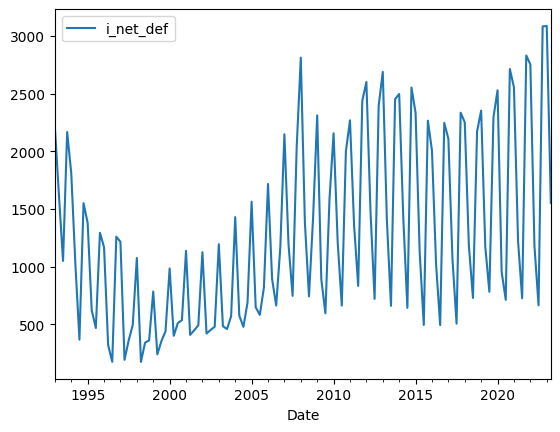

In [50]:
def split_df(df, date, date_format):
    df_train = df[df.index < pd.to_datetime(date, format=date_format)]
    df_test = df[df.index >= pd.to_datetime(date, format=date_format)]
    return df_train, df_test

finish_date = "2022-01-01"
# date_format: "YYYY-MM-DD"
date_format = "%Y-%m-%d"

I = data[["i_net_def", "Date"]]
I.set_index("Date", inplace=True)
I.plot()
I_train, I_test = split_df(I, finish_date, date_format)

In [51]:
# ---
#pip install sktime

In [52]:
def plot (data, title = None, ylabel = None):
    fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)

    ax.set(title= title)
    ax.plot(data,'b-')
    ax.xaxis_date()
    ax.set_xlabel('дата')
    ax.set_ylabel(ylabel)

    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    return(plt.show())


def acf_pacf (data):
    sm.graphics.tsa.plot_acf(data, zero = False)
    sm.graphics.tsa.plot_pacf(data, method = 'ywm', zero = False)
    return(plt.show())

def plot_sa (data, periods = 4) :
    result1 = sm.tsa.seasonal_decompose(data, model='additive', period = periods).plot()
    return(result1)

def kpss_adf(data, regression):
    kpss_test(data, regression)
    print("-" * 100)
    print(adf_test(data, regression).summary())

def MAPE(Y_actual, Y_Predicted):
    mape = ((np.abs((Y_actual - Y_Predicted)/Y_actual))*100).mean()
    return mape 


def MAE(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

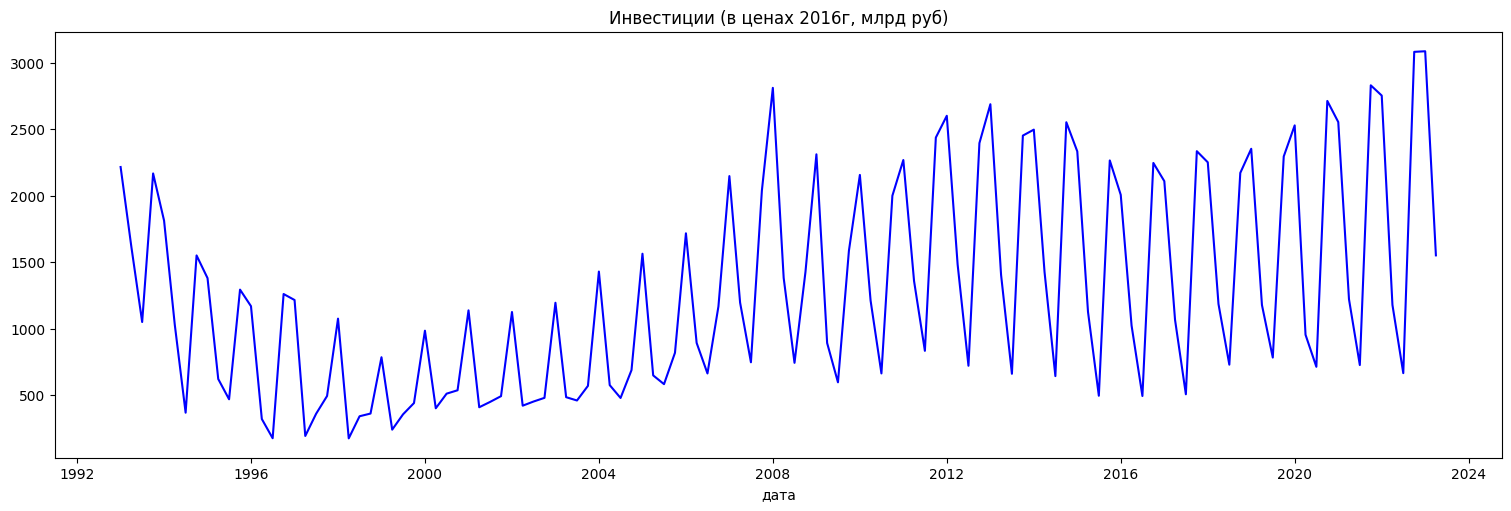

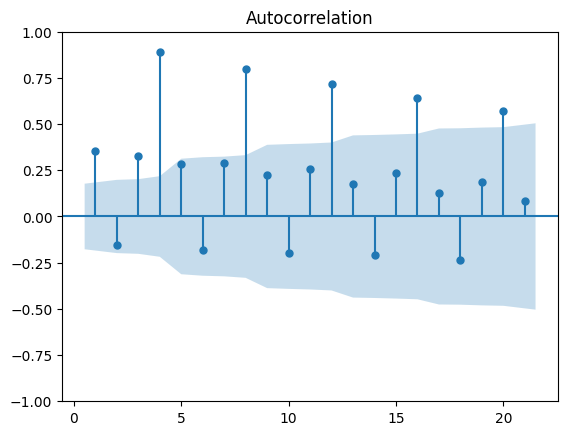

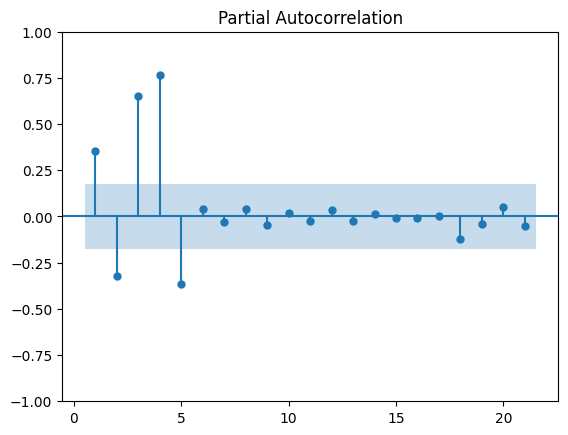

Results of KPSS Test:
ряд стационарен



Test Statistic            0.105799
p-value                   0.100000
#Lags Used               14.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
ряд НЕ является стационарным



Test Statistic                  -3.273667
p-value                          0.070696
#Lags Used                       5.000000
Number of Observations Used    116.000000
Critical Value (1%)             -4.039013
Critical Value (5%)             -3.449039
Critical Value (10%)            -3.149646
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:             

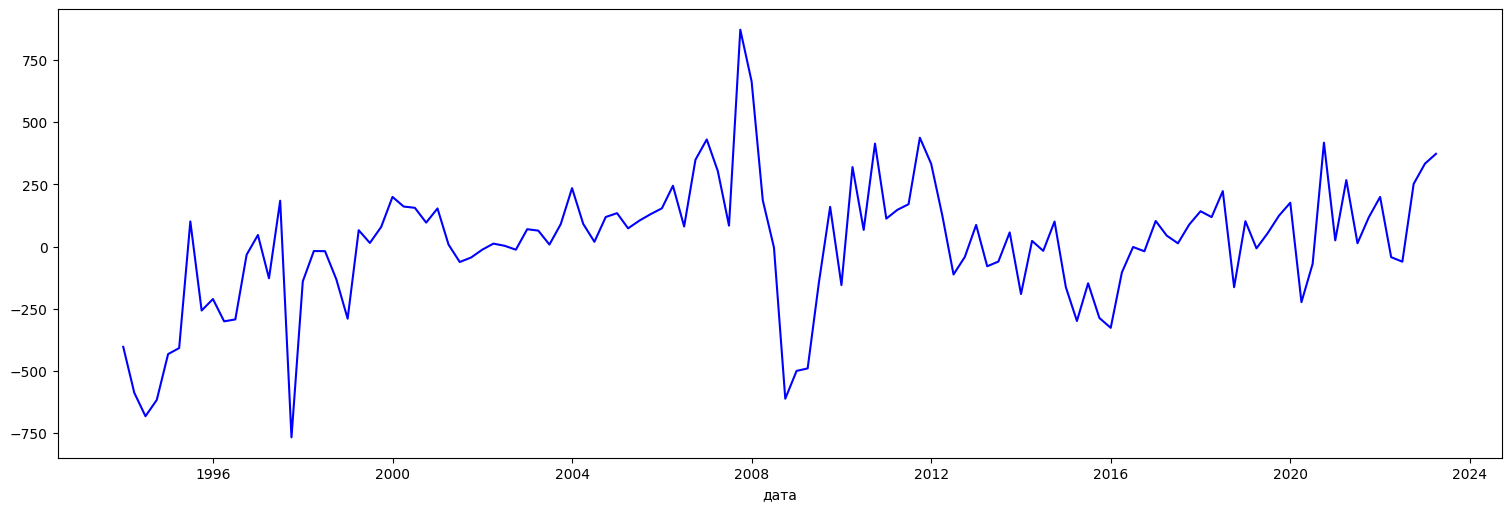

AUTO ARIMA НА ИСХОДНЫХ
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=1591.711, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=1608.966, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=1594.770, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=1589.984, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=1591.122, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=1591.949, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=1591.916, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=1590.296, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=1609.763, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=1588.302, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=1586.954, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=1588.335, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=1590.294, Time=0.19 sec
 ARIMA(1,1,0)(0

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(0, 1, 0, 4),
      suppress_warnings=True, with_intercept=False)

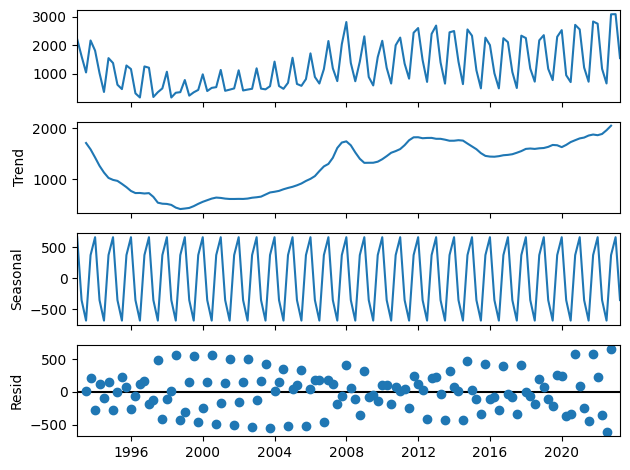

In [53]:
I
plot(I, 'Инвестиции (в ценах 2016г, млрд руб)')
acf_pacf(I)
kpss_adf(I, "ct")

# тесты проходит (> 0.05) => стационарен по константе
# по тренду проходит тоже

# извлекаем сезонность
I_s = (I - I.shift(4)).dropna()
plot(I_s)
plot_sa(I)
print('AUTO ARIMA НА ИСХОДНЫХ')
model = auto_arima(
    I, 
    seasonal=True, 
    m = 4, 
    trace=True, 
    suppress_warnings=True, 
    error_action='ignore', 
    stepwise= True, 
    max_order = 7
)
model


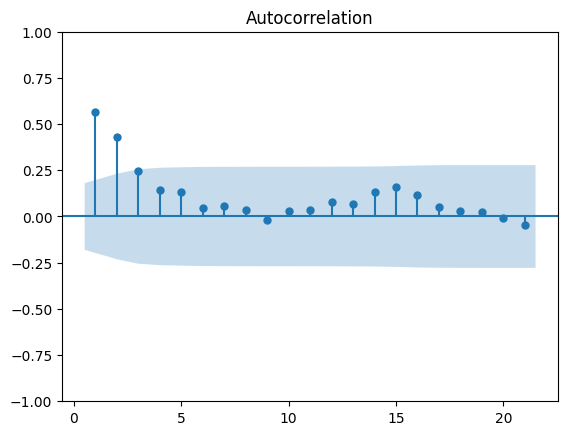

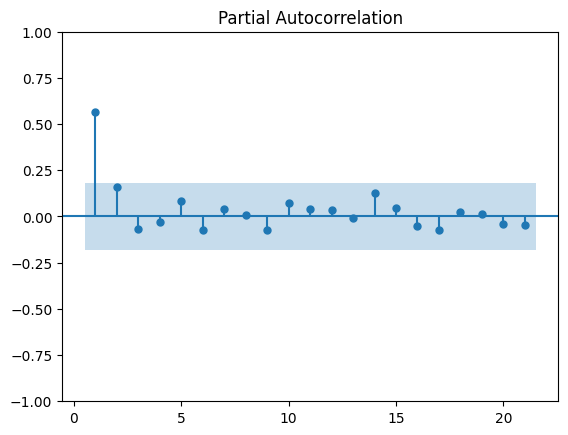

Results of KPSS Test:
ряд НЕ стационарен



Test Statistic           0.193623
p-value                  0.018392
#Lags Used               5.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64
----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
ряд является стационарным



Test Statistic                  -4.491156
p-value                          0.001561
#Lags Used                       1.000000
Number of Observations Used    116.000000
Critical Value (1%)             -4.039013
Critical Value (5%)             -3.449039
Critical Value (10%)            -3.149646
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.

In [54]:
# после сезонности
acf_pacf(I_s)
kpss_adf(I_s, "ct")

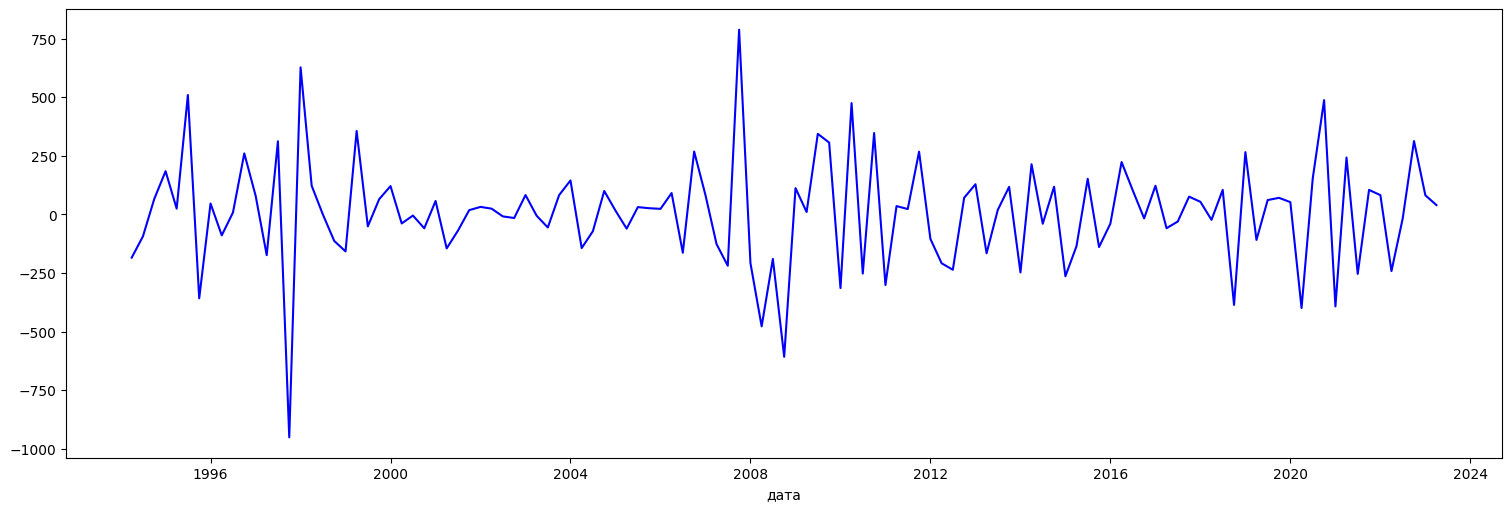

In [55]:
# берем лаг - приводим к стационарному формату
I_ls = (I_s - I_s.shift(1)).dropna()
plot(I_ls)

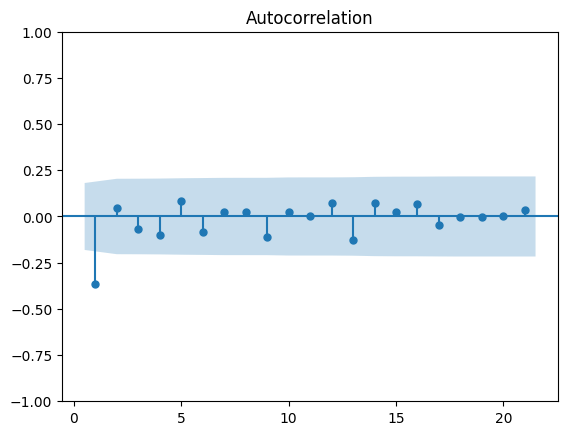

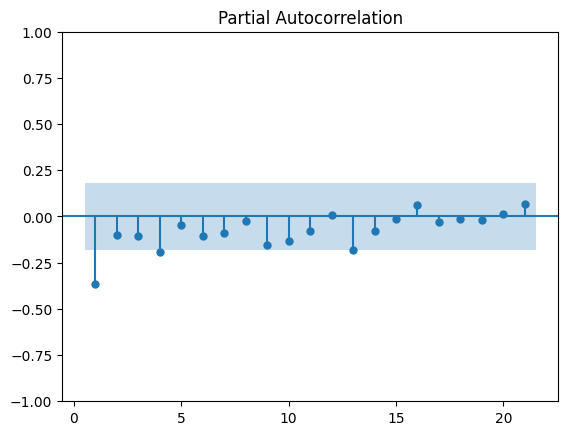

Results of KPSS Test:
ряд стационарен



Test Statistic           0.048986
p-value                  0.100000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
ряд является стационарным



Test Statistic                -7.539576e+00
p-value                        3.406256e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:         

In [56]:
# после взятия разности
acf_pacf(I_ls)
kpss_adf(I_ls, 'c')

102 20


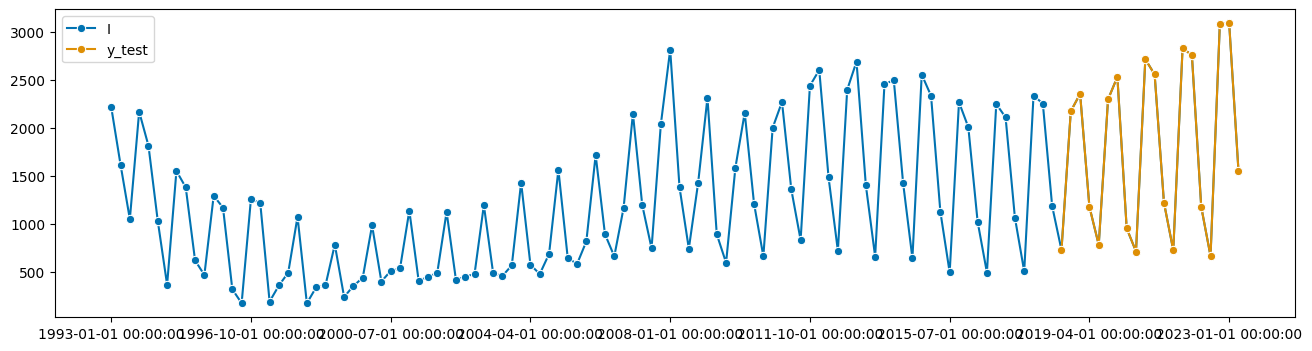

In [57]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

y_train, y_test = temporal_train_test_split(I, test_size=20)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(
    I, 
    #y_train, 
    y_test, 
    labels=[
        "I",
        #"y_train", 
        "y_test"
    ]
)
#plot(I)
print(y_train.shape[0], y_test.shape[0])

In [58]:
import pmdarima as pm

In [59]:
arima_model = pm.auto_arima(
    
    y_train,
    start_p=2, start_q=1,
    max_p=2, max_q=1, 
    
    seasonal=True, m=4,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,
    # d = 1,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
    
    # Можно делать перебор гипер-параметров 
    # на основе метрики на тестовой выборке
    #scoring='mae',
)

 ARIMA(0,1,0)(0,1,0)[4]             : BIC=1335.833, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4]             : BIC=1339.600, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[4]             : BIC=1343.991, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[4]             : BIC=1339.310, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[4]             : BIC=1344.099, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[4]             : BIC=1346.820, Time=0.13 sec
 ARIMA(0,1,0)(2,1,0)[4]             : BIC=1344.075, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[4]             : BIC=1347.754, Time=0.16 sec
 ARIMA(0,1,0)(2,1,2)[4]             : BIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[4]             : BIC=1327.568, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : BIC=1329.435, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[4]             : BIC=1333.992, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[4]             : BIC=1329.670, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : BIC=1334.001, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : BIC=1337.767, Time=0.17 sec
 ARIMA(0,1,1)(2

In [60]:
y_pred, pred_ci = arima_model.predict(
    n_periods=20, 
    return_conf_int=True, 
    alpha=0.05
)


In [61]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = list(fh)
df_forecast.head()

,y_pred,ci_lower,ci_upper
2018-07-01,573.242815,149.726224,996.759405
2018-10-01,2376.284687,1883.782146,2868.787228
2019-01-01,2279.769467,1760.461394,2799.077539
2019-04-01,1207.006806,673.782398,1740.231213
2019-07-01,592.613378,-153.972555,1339.199311


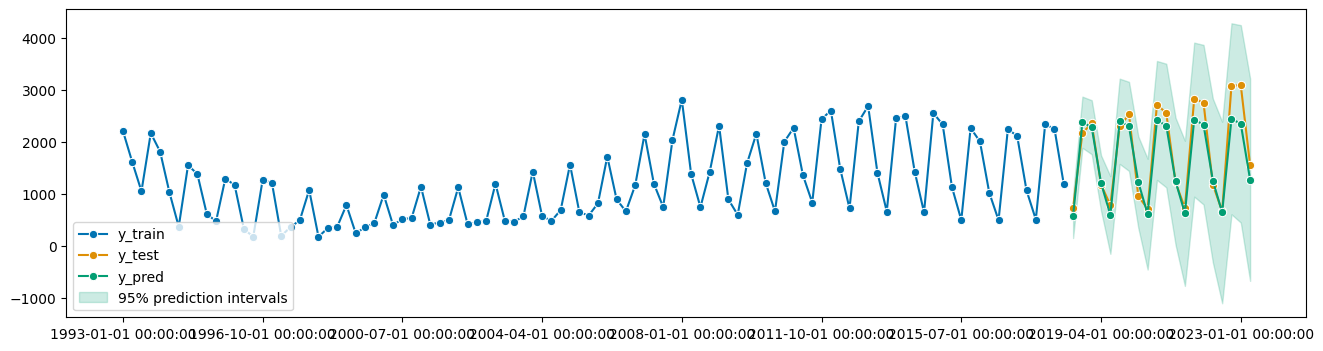

In [62]:
fig, ax = plot_series(y_train, y_test, df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label="95% prediction intervals",
)
ax.legend(loc='lower left')